In [18]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


from modules.data_fetcher import download_historical_data

# Transformer encoder


In [27]:
symbol = "BTC-USDT"

df = download_historical_data(symbol, "1hour").loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
df["Target"] = (df["Close"].shift(-5) > df["Close"]).astype(int)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,Log_Volume,Vol20,EMA20,Target
Date,,,,,,,,,,,,,,
2020-11-20 20:00:00,1.605899e+09,18582.6,18626.1,18658.0,18532.6,37.037587,6.893380e+05,9.832319,0.002341,0.000238,13.443487,0.000658,18338.482479,1
2020-11-20 21:00:00,1.605902e+09,18626.2,18627.1,18687.6,18558.7,48.514027,9.047119e+05,9.832373,0.000054,0.000005,13.715372,0.000654,18359.364784,1
2020-11-20 22:00:00,1.605906e+09,18627.0,18576.5,18645.1,18512.4,58.444076,1.086463e+06,9.829653,-0.002716,-0.000277,13.898438,0.000633,18374.695941,1
2020-11-20 23:00:00,1.605910e+09,18576.5,18617.3,18619.7,18488.7,51.350270,9.529672e+05,9.831847,0.002196,0.000223,13.767336,0.000631,18391.440450,1
2020-11-21 00:00:00,1.605913e+09,18617.3,18659.4,18721.5,18550.9,95.569442,1.782114e+06,9.834105,0.002261,0.000230,14.393311,0.000629,18409.547487,0


In [28]:
std_scaler = StandardScaler()

X, y = (
    std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    df["Target"].values,
)  # to_categorical(df['Target'].values)

n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1], 1)), y, test_size=0.2, shuffle=False
)

x_train, y_train

(array([[[-1.20338239e+00],
         [-1.20032174e+00],
         [-1.20477630e+00],
         ...,
         [-2.50415090e+00],
         [ 1.18638058e-02],
         [-1.22237741e+00]],
 
        [[-1.20025086e+00],
         [-1.20024992e+00],
         [-1.20266252e+00],
         ...,
         [-2.22756841e+00],
         [ 5.20178823e-04],
         [-1.22087498e+00]],
 
        [[-1.20019340e+00],
         [-1.20388430e+00],
         [-1.20569750e+00],
         ...,
         [-2.04133906e+00],
         [-5.59214921e-02],
         [-1.21977194e+00]],
 
        ...,
 
        [[-1.13405790e+00],
         [-1.13182148e+00],
         [-1.13653578e+00],
         ...,
         [ 2.93758101e-01],
         [-1.04203714e+00],
         [-1.14594302e+00]],
 
        [[-1.13168771e+00],
         [-1.13372486e+00],
         [-1.13832820e+00],
         ...,
         [ 5.18516077e-02],
         [-1.06097120e+00],
         [-1.14542070e+00]],
 
        [[-1.13365569e+00],
         [-1.12723899e+00],
    

In [29]:
from tensorflow import keras

from tensorflow.keras import layers

"""
We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.
The projection layers are implemented through `keras.layers.Conv1D`.
"""


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(
        x
    )  # layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


"""
## Train and evaluate
"""

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",  # loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # AdamW or NovoGrad
    metrics=["accuracy"],  # metrics=["sparse_categorical_accuracy"],
)


model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
209/209 [==============================] - 76s 296ms/step - loss: 0.7093 - accuracy: 0.5052 - val_loss: 0.7166 - val_accuracy: 0.4864
Epoch 2/200
209/209 [==============================] - 66s 314ms/step - loss: 0.7069 - accuracy: 0.4957 - val_loss: 0.7092 - val_accuracy: 0.4855
Epoch 3/200
209/209 [==============================] - 99s 472ms/step - loss: 0.7015 - accuracy: 0.5102 - val_loss: 0.7052 - val_accuracy: 0.4831
Epoch 4/200
209/209 [==============================] - 96s 459ms/step - loss: 0.6987 - accuracy: 0.5127 - val_loss: 0.7022 - val_accuracy: 0.4825
Epoch 5/200
209/209 [==============================] - 99s 476ms/step - loss: 0.6993 - accuracy: 0.5076 - val_loss: 0.7023 - val_accuracy: 0.4804
Epoch 6/200
209/209 [==============================] - 92s 441ms/step - loss: 0.6969 - accuracy: 0.5135 - val_loss: 0.7020 - val_accuracy: 0.4807
Epoch 7/200
209/209 [==============================] - 59s 281ms/step - loss: 0.6972 - accuracy: 0.5230 - val_loss: 0.7015 -

[0.6959822773933411, 0.5029911398887634]

# Time2Vec


## Example 1


In [ ]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name="Time2VecLayer")
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(
            name="wb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        self.bb = self.add_weight(
            name="bb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        # periodic
        self.wa = self.add_weight(
            name="wa",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        self.ba = self.add_weight(
            name="ba",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = np.dot(inputs, self.wa) + self.ba
        wgts = np.sin(dp)  # or np.cos(.)

        ret = np.concatenate([np.expand_dims(bias, -1), wgts], -1)
        ret = np.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

In [ ]:
from tensorflow_addons.layers import MultiHeadAttention


class AttentionBlock(keras.Model):
    def __init__(
        self,
        name="AttentionBlock",
        num_heads=2,
        head_size=128,
        ff_dim=None,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(
            num_heads=num_heads, head_size=head_size, dropout=dropout
        )
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(
            filters=ff_dim, kernel_size=1, activation="relu"
        )
        # self.ff_conv2 at build()
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1)

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)

        x = self.ff_norm(inputs + x)
        return x

In [ ]:
class ModelTrunk(keras.Model):
    def __init__(
        self,
        name="ModelTrunk",
        time2vec_dim=1,
        num_heads=2,
        head_size=128,
        ff_dim=None,
        num_layers=1,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        if ff_dim is None:
            ff_dim = head_size
        self.dropout = dropout
        self.attention_layers = [
            AttentionBlock(
                num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout
            )
            for _ in range(num_layers)
        ]

    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs)
        x = np.concatenate([inputs, time_embedding], -1)
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return np.reshape(
            x, (-1, x.shape[1] * x.shape[2])
        )  # flat vector of features out

In [ ]:
def lr_scheduler(
    epoch,
    lr,
    warmup_epochs=15,
    decay_epochs=100,
    initial_lr=1e-6,
    base_lr=1e-3,
    min_lr=5e-5,
):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr


# callbacks += [
#     keras.callbacks.LearningRateScheduler(partial(lr_scheduler, ...), verbose=0)
# ]

## Example 2


In [75]:
symbol = "BTC-USDT"

df = download_historical_data(symbol, "4hour").loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
for i in [1, 2, 5, 10, 20, 50, 100, 200]:
    df[f"Close_lag{i}"] = df.Close.shift(i)
df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,...,EMA20,Close_lag1,Close_lag2,Close_lag5,Close_lag10,Close_lag20,Close_lag50,Close_lag100,Close_lag200,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-23 09:00:00,1608710400,23560.9,23064.7,23728.2,22809.6,551.324950,1.281480e+07,10.046059,-0.021193,-0.002128,...,22669.185692,23564.1,23705.4,23346.5,22814.8,23348.1,19483.7,19130.2,17953.5,23450.6
2020-12-23 13:00:00,1608724800,23059.8,23450.6,24125.0,22934.7,739.185091,1.746226e+07,10.062651,0.016731,0.001652,...,22706.397849,23064.7,23564.1,23403.7,22717.5,23625.5,19193.4,19362.6,18206.2,23551.4
2020-12-23 17:00:00,1608739200,23450.6,23551.4,23675.0,23359.9,292.121447,6.878301e+06,10.066941,0.004298,0.000426,...,22746.638057,23450.6,23064.7,23813.1,22855.6,23553.9,19293.8,19280.0,18263.8,23230.7
2020-12-23 21:00:00,1608753600,23551.5,23230.7,23620.0,22615.8,811.668784,1.886444e+07,10.053230,-0.013617,-0.001362,...,22769.689723,23551.4,23450.6,23705.4,22654.0,23871.1,19408.9,19370.7,18664.5,22885.6
2020-12-24 01:00:00,1608768000,23232.5,22885.6,23239.4,22705.7,595.459410,1.368367e+07,10.038263,-0.014855,-0.001489,...,22775.209510,23230.7,23551.4,23564.1,23121.1,23937.9,19532.5,19104.5,18626.1,23170.1


In [83]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X, y = (
    std_scaler.fit_transform(df["Close"].values.reshape(-1, 1)),
    # std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    minmax_scaler.fit_transform(df["Target"].values.reshape(-1, 1)),
)
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1])), y, test_size=0.2, shuffle=True
)

x_train, y_train

(array([[-1.38145129],
        [ 0.69075473],
        [-0.25763503],
        ...,
        [ 0.18723648],
        [ 0.19039817],
        [-1.37661109]]),
 array([[0.022143  ],
        [0.56606586],
        [0.31401834],
        ...,
        [0.43556685],
        [0.4312471 ],
        [0.02285411]]))

In [84]:
class T2V(keras.layers.Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.P = self.add_weight(
            name="P",
            shape=(input_shape[1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.w = self.add_weight(
            name="w", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        self.p = self.add_weight(
            name="p", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.p
        sin_trans = tf.math.sin(tf.matmul(x, self.W) + self.P)

        return tf.concat([sin_trans, original], -1)

In [85]:
def T2V_NN(
    dim: int,
    param: dict[str, int | float | str] = {
        "act": "relu",
        "t2v_dim": 16,
        "unit": 32,
        "lr": 1e-4,
    },
):
    inp = keras.layers.Input(shape=(dim, 1))
    x = T2V(param["t2v_dim"])(inp)
    x = keras.layers.LSTM(param["unit"], activation=param["act"])(x)
    x = keras.layers.Dense(1)(x)

    m = keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m


def NN(
    dim: int,
    param: dict[str, int | float | str] = {"act": "relu", "unit": 32, "lr": 1e-4},
):
    inp = keras.layers.Input(shape=(dim, 1))
    x = keras.layers.LSTM(param["unit"], activation=param["act"])(inp)
    x = keras.layers.Dense(1)(x)

    m = keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m

In [86]:
T2V_model = T2V_NN(1, {"t2v_dim": 16, "act": "relu", "unit": 32, "lr": 1e-4})
T2V_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

T2V_model.evaluate(x_test, y_test)


Epoch 1/100
26/26 [==============================] - 7s 23ms/step - loss: 0.2031 - mean_absolute_error: 0.3718 - val_loss: 0.2014 - val_mean_absolute_error: 0.3682
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 0.1965 - mean_absolute_error: 0.3643 - val_loss: 0.1946 - val_mean_absolute_error: 0.3606
Epoch 3/100
26/26 [==============================] - 0s 12ms/step - loss: 0.1896 - mean_absolute_error: 0.3565 - val_loss: 0.1875 - val_mean_absolute_error: 0.3525
Epoch 4/100
26/26 [==============================] - 0s 10ms/step - loss: 0.1824 - mean_absolute_error: 0.3484 - val_loss: 0.1800 - val_mean_absolute_error: 0.3442
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 0.1746 - mean_absolute_error: 0.3399 - val_loss: 0.1717 - val_mean_absolute_error: 0.3353
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 0.1660 - mean_absolute_error: 0.3307 - val_loss: 0.1628 - val_mean_absolute_error: 0.3258
Epoch 7/100
26/26 

[0.00013355327246244997, 0.007526720408350229]

In [87]:
LSTM_model = NN(1, {"act": "relu", "unit": 32, "lr": 1e-4})

LSTM_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

LSTM_model.evaluate(x_test, y_test)


Epoch 1/100
26/26 [==============================] - 18s 247ms/step - loss: 0.2439 - mean_absolute_error: 0.4085 - val_loss: 0.2421 - val_mean_absolute_error: 0.4048
Epoch 2/100
26/26 [==============================] - 1s 39ms/step - loss: 0.2358 - mean_absolute_error: 0.4001 - val_loss: 0.2341 - val_mean_absolute_error: 0.3965
Epoch 3/100
26/26 [==============================] - 1s 27ms/step - loss: 0.2281 - mean_absolute_error: 0.3919 - val_loss: 0.2265 - val_mean_absolute_error: 0.3884
Epoch 4/100
26/26 [==============================] - 1s 22ms/step - loss: 0.2206 - mean_absolute_error: 0.3840 - val_loss: 0.2190 - val_mean_absolute_error: 0.3806
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 0.2133 - mean_absolute_error: 0.3763 - val_loss: 0.2118 - val_mean_absolute_error: 0.3729
Epoch 6/100
26/26 [==============================] - 1s 22ms/step - loss: 0.2063 - mean_absolute_error: 0.3688 - val_loss: 0.2048 - val_mean_absolute_error: 0.3654
Epoch 7/100
26

[0.0006408311310224235, 0.02077818475663662]

In [90]:
tsv = T2V_model.predict(x_test)
lstm = LSTM_model.predict(x_test)


32/32 [==============================] - 1s 12ms/step


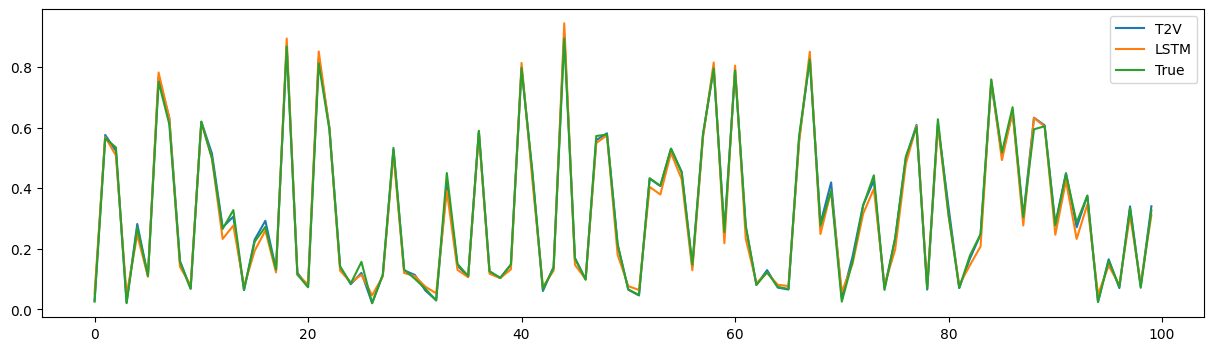

In [92]:
fig, ax = plt.subplots(1,1, figsize=(15, 4))
ax.plot(tsv[-100:], label="T2V")
ax.plot(lstm[-100:], label="LSTM")
ax.plot(y_test[-100:], label="True")
ax.legend()